<a href="https://colab.research.google.com/github/ZeynelAbidin91/DL-in-Computer-vision/blob/master/VGG19_cat_dog_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils #???
from keras import backend as K
from keras.optimizers import Adam

from tensorflow.keras.applications import VGG19

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG # ????
from keras.utils.vis_utils import model_to_dot 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.4.3 backend: tensorflow


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files # to load image data
uploaded = files.upload()   

Saving Data.zip to Data.zip


In [ ]:
!unzip Data.zip 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 
train_data_gen = ImageDataGenerator(rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) 

scaled_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_set = train_data_gen.flow_from_directory('Data/train/', 
                                                   target_size=(150, 150),
                                                   class_mode='binary', 
                                                   batch_size=32)
eval_set = scaled_data_gen.flow_from_directory('Data/eval/', 
                                                   target_size=(150, 150),
                                                   class_mode='binary',
                                                   batch_size=32)
test_set = scaled_data_gen.flow_from_directory('Data/test/', 
                                                   target_size=(150, 150),
                                                   class_mode='binary', 
                                                   batch_size=32)

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
input_shape = train_set[0][0].shape[1:4]
input_shape

(150, 150, 3)

**Transfer Learning with VGG19**







In [ ]:
# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

In [ ]:
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

def define_model(): # CNN image classifier model as function

  model = Sequential()

  model.add(vgg_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=524, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=1, activation='sigmoid'))
  vgg_base.trainable = False

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model
#print(model.summary())


80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
model = define_model() 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 524)               537100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 524)               0

In [ ]:
%%time

epochs = 10 

history = model.fit_generator(train_set,
                                  steps_per_epoch=len(train_set), 
                                  epochs=epochs, validation_data=eval_set, 
                                  validation_steps=len(eval_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
313/313 [==============================] - 83s 267ms/step - loss: 0.5528 - accuracy: 0.7328 - val_loss: 0.3980 - val_accuracy: 0.8130
Epoch 2/10
313/313 [==============================] - 84s 268ms/step - loss: 0.4415 - accuracy: 0.7944 - val_loss: 0.3156 - val_accuracy: 0.8750
Epoch 3/10
313/313 [==============================] - 84s 267ms/step - loss: 0.4242 - accuracy: 0.7979 - val_loss: 0.2728 - val_accuracy: 0.8792
Epoch 4/10
313/313 [==============================] - 84s 268ms/step - loss: 0.4116 - accuracy: 0.8093 - val_loss: 0.2725 - val_accuracy: 0.8802
Epoch 5/10
313/313 [==============================] - 84s 268ms/step - loss: 0.4025 - accuracy: 0.8125 - val_loss: 0.2774 - val_accuracy: 0.8800
Epoch 6/10
313/313 [==============================] - 84s 269ms/step - loss: 0.4099 - accuracy: 0.8081 - val_loss: 0.2643 - val_accuracy: 0.8842
Epoch 7/10
313/313 [==============================] - 

Text(0.5, 1.0, 'accuracy')

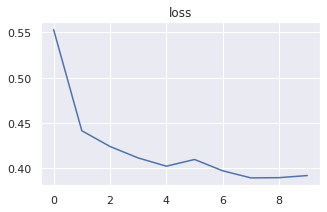

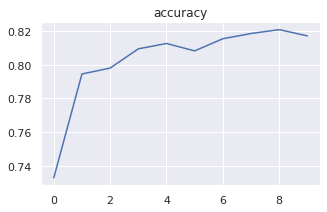

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy')

In [ ]:
# evaluate performance on train & test data
loss, acc = model.evaluate_generator(train_set, steps=len(train_set), verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_set, steps=len(eval_set), verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc)) 

Instructions for updating:
Please use Model.evaluate, which supports generators.
313/313 [==============================] - 72s 229ms/step - loss: 0.3471 - accuracy: 0.8434
Training data  -> loss: 0.347, acc: 0.843
125/125 [==============================] - 12s 96ms/step - loss: 0.2680 - accuracy: 0.8800
Cross-val data -> loss: 0.268, acc: 0.880
32/32 [==============================] - 3s 99ms/step - loss: 0.2540 - accuracy: 0.8790
Testing data   -> loss: 0.254, acc: 0.879



Model | Train | Cross-val | Test
--- | --- | --- | ---
Base-model | 0.84 | 0.78 | 0.80
Augmented model | 0.73 | 0.75 | 0.76
Transfer learning | 0.84 |0.88 | 0.87

**Fine-Tuning with VGG19**

In [ ]:
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

def fine_tuning_model(): # CNN image classifier model as function

  model = Sequential()

  model.add(vgg_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=524, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=1, activation='sigmoid'))


  for layer in vgg_base.layers[:19]:
    layer.trainable = False
  for layer in vgg_base.layers[19:]:
    layer.trainable = True
  


  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model

In [ ]:
model_tuning = fine_tuning_model() 
print(model_tuning.summary())
#print(vgg_base.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 524)               537100    
_________________________________________________________________
dropout_32 (Dropout)         (None, 524)             

In [ ]:
# to see unfroze layers 
for layer in vgg_base.layers:
  print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f89574332b0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8957433400>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8957433710>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8957433cf8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f895748aeb8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8957429e10>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f895742c780>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f895742c9e8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8957438860>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8957438908>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f89573c1860>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D

In [ ]:
%%time

epochs = 10 

history = model_tuning.fit_generator(train_set,
                                  steps_per_epoch=len(train_set), 
                                  epochs=epochs, validation_data=eval_set, 
                                  validation_steps=len(eval_set)) 

Epoch 1/10
313/313 [==============================] - 82s 264ms/step - loss: 0.5973 - accuracy: 0.7196 - val_loss: 0.3922 - val_accuracy: 0.8560
Epoch 2/10
313/313 [==============================] - 82s 263ms/step - loss: 0.4522 - accuracy: 0.7963 - val_loss: 0.3195 - val_accuracy: 0.8545
Epoch 3/10
313/313 [==============================] - 83s 264ms/step - loss: 0.4096 - accuracy: 0.8181 - val_loss: 0.2907 - val_accuracy: 0.8890
Epoch 4/10
313/313 [==============================] - 83s 264ms/step - loss: 0.3708 - accuracy: 0.8379 - val_loss: 0.2835 - val_accuracy: 0.8823
Epoch 5/10
313/313 [==============================] - 83s 264ms/step - loss: 0.3315 - accuracy: 0.8640 - val_loss: 0.2932 - val_accuracy: 0.8875
Epoch 6/10
313/313 [==============================] - 83s 264ms/step - loss: 0.3021 - accuracy: 0.8706 - val_loss: 0.2670 - val_accuracy: 0.9053
Epoch 7/10
313/313 [==============================] - 83s 265ms/step - loss: 0.2752 - accuracy: 0.8833 - val_loss: 0.2437 - val_ac

Text(0.5, 1.0, 'accuracy')

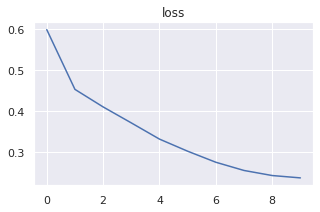

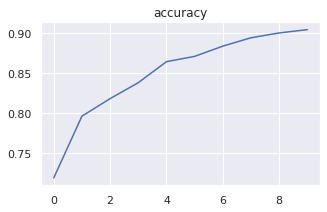

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss') 

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy')

In [ ]:
# evaluate performance on train & test data
loss, acc = model_tuning.evaluate_generator(train_set, steps=len(train_set), verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_tuning.evaluate_generator(eval_set, steps=len(eval_set), verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_tuning.evaluate_generator(test_set, steps=len(test_set), verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc)) 

313/313 [==============================] - 70s 223ms/step - loss: 0.2256 - accuracy: 0.9071
Training data  -> loss: 0.226, acc: 0.907
125/125 [==============================] - 12s 93ms/step - loss: 0.2239 - accuracy: 0.9082
Cross-val data -> loss: 0.224, acc: 0.908
32/32 [==============================] - 3s 89ms/step - loss: 0.2066 - accuracy: 0.9100
Testing data   -> loss: 0.207, acc: 0.910


Model | Train | Cross-val | Test
--- | --- | --- | ---
Base-model | 0.84 | 0.78 | 0.80
Augmented model | 0.73 | 0.75 | 0.76
Transfer learning | 0.84 |0.88 | 0.87
Fine-tuning | 0.9071 | 0.9082 | 0.91



*   In the end we managed to get 0.91 accuracy on test set. We can clearly see that each model that is applied to data, gradually improved our results. It'd be more likely to reach better accuracies if we trained data with more epochs.
*   So far, with data augmentation methods more data added to reduce overfitting.
*   With transfer learning, by applying pre-trained model VGG19, better results obtained instead of building a new CNN model. This process is called feature extraction via transfer learning
*   And finally, by unfreezing last couple of layers in the pre-trained model, we let the model to recognize new data which is not originally trained. So that this method allows us to obtain higher accuracy. This process is called fine-tunning via transfer learning.

